# Ensemble method of 16S sequencing data using Random Forest Regressor

The data collected here are based on 3 MSc students' 16S sequencing from a gut model called the Simulator of the Human Intestinal Microbial Ecosystem. 

Some key limitations for this exercise:
* Data has not been normalized. Each student collected the data at different timepoints. For the purpose of this exercise, and with the exception of data collected before the experiment (noted as a negative number), all timepoints are sequentially written starting from 0. 
* Sequencing methods affect the abundance of different taxa, but were ignored for this exercise.
* This model is meant to demonstrate a starting point to for the prediction of taxa abundance. Future work is discussed at the end. 

## Questions of interest

1. Which taxa is more associated with change? 
2. Can we predict changes in the relative abundance of the different taxa over time? 
3. What would be the best model to use for this dataset?

## Steps for this NGS machine learning model

1. Load the data
    * Note: Since these data were from different projects, they were compiled outside of Python (i.e., using Excel) before being loaded. 
2. Clean the data
3. Exploratory data analysis
4. Modelling
5. Evaluating the model
6. Improving the model
7. Conclusion and future work

In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error

### 1. Load the data

In [2]:
phyla = pd.read_csv("phyla_new.csv")

In [3]:
phyla.shape, phyla.head()

((825, 11),
    Timepoint  Actinobacteria  Bacteroidetes  Desulfobacterota  Firmicutes  \
 0        -10            53.0          420.0               NaN       822.0   
 1        -10            55.0          124.0              84.0        28.0   
 2        -10            55.0          111.0               NaN      1045.0   
 3        -10            82.0          441.0               NaN       900.0   
 4        -10            93.0           97.0               NaN       918.0   
 
    Proteobacteria  Acidobacteria  Euryarchaeota  Lentisphaerae  Synergistetes  \
 0             NaN            NaN            NaN            NaN            NaN   
 1           185.0            NaN            NaN            NaN            NaN   
 2             NaN            NaN            NaN            NaN            NaN   
 3             NaN            NaN            NaN            NaN            NaN   
 4             NaN            NaN            NaN            NaN            NaN   
 
    Verrucomicrobia  
 0

### 2. Clean the data

In [4]:
# Rename columns and switch to lower case

def rename_n_lower(df):
    df.rename({'Timepoint': 'time'}, axis=1, inplace=True)
    df.columns = [x.lower() for x in df.columns]
    return df
rename_n_lower(phyla)

,time,actinobacteria,bacteroidetes,desulfobacterota,firmicutes,proteobacteria,acidobacteria,euryarchaeota,lentisphaerae,synergistetes,verrucomicrobia
0,-10,53.0,420.0,NaN,822.00000,NaN,NaN,NaN,NaN,NaN,NaN
1,-10,55.0,124.0,84.0,28.00000,185.00000,NaN,NaN,NaN,NaN,NaN
2,-10,55.0,111.0,NaN,1045.00000,NaN,NaN,NaN,NaN,NaN,NaN
3,-10,82.0,441.0,NaN,900.00000,NaN,NaN,NaN,NaN,NaN,NaN
4,-10,93.0,97.0,NaN,918.00000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
820,9,NaN,NaN,NaN,2596.00000,NaN,NaN,NaN,NaN,NaN,NaN
821,9,NaN,NaN,NaN,2186.00000,NaN,NaN,NaN,NaN,NaN,NaN
822,9,NaN,NaN,NaN,2139.00000,NaN,NaN,NaN,NaN,NaN,NaN
823,9,NaN,NaN,NaN,61.00000,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check for missing values

phyla.isna().sum()

time                  0
actinobacteria      749
bacteroidetes       413
desulfobacterota    797
firmicutes            0
proteobacteria      579
acidobacteria       813
euryarchaeota       814
lentisphaerae       793
synergistetes       777
verrucomicrobia     771
dtype: int64

In [6]:
# Check for any strings

for label, content in phyla.items(): # .items() treats the DF like a dictionary
    if pd.api.types.is_string_dtype(content):
        print(label)
# No string values

In [7]:
# Turn categorical variables into numbers

for label, content in phyla.items():
    # Check columns which *aren't* numeric
    # if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        phyla[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        phyla[label] = pd.Categorical(content).codes+1  # turning all non numeric column values into positive values 

Let's check that our data has been cleaned properly and that we have no strings in our columns and no null values.

In [9]:
phyla.info(), phyla.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   time                         825 non-null    int8 
 1   actinobacteria               825 non-null    int8 
 2   bacteroidetes                825 non-null    int16
 3   desulfobacterota             825 non-null    int8 
 4   firmicutes                   825 non-null    int16
 5   proteobacteria               825 non-null    int16
 6   acidobacteria                825 non-null    int8 
 7   euryarchaeota                825 non-null    int8 
 8   lentisphaerae                825 non-null    int8 
 9   synergistetes                825 non-null    int8 
 10  verrucomicrobia              825 non-null    int8 
 11  time_is_missing              825 non-null    bool 
 12  actinobacteria_is_missing    825 non-null    bool 
 13  bacteroidetes_is_missing     825 non-null    bool 

(None,
 time                           0
 actinobacteria                 0
 bacteroidetes                  0
 desulfobacterota               0
 firmicutes                     0
 proteobacteria                 0
 acidobacteria                  0
 euryarchaeota                  0
 lentisphaerae                  0
 synergistetes                  0
 verrucomicrobia                0
 time_is_missing                0
 actinobacteria_is_missing      0
 bacteroidetes_is_missing       0
 desulfobacterota_is_missing    0
 firmicutes_is_missing          0
 proteobacteria_is_missing      0
 acidobacteria_is_missing       0
 euryarchaeota_is_missing       0
 lentisphaerae_is_missing       0
 synergistetes_is_missing       0
 verrucomicrobia_is_missing     0
 dtype: int64)

### 3. Exploring the data

<AxesSubplot:ylabel='Frequency'>

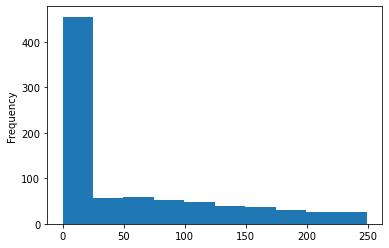

In [10]:
phyla["bacteroidetes"].plot.hist()

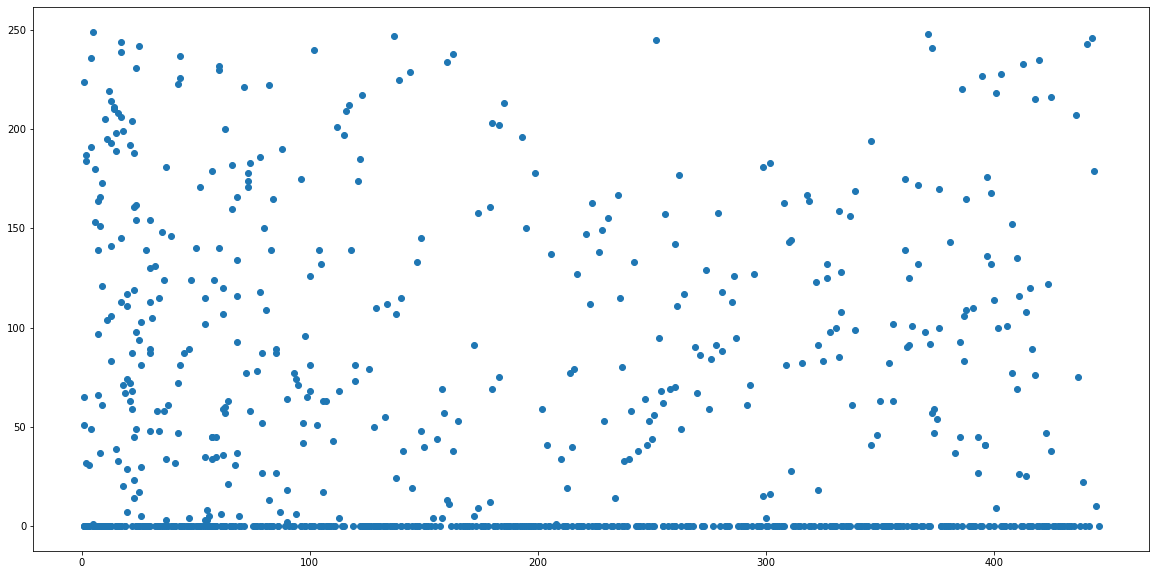

In [11]:
# Let's see relationship of firmicutes (x-axis) and bacteroidetes (y-axis)

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(phyla["firmicutes"][:1000], phyla["bacteroidetes"][:1000]) 
pass

Seems that exploring the data might not be the best option after filling in the null values, but let's continue with the modelling

### 4. Modelling

For this first model, we will be setting the Firmicutes as the target variable as they are the most abundant and it may be interesting to see what features (taxa/time) are most important to the abundance of Firmicutes.

**Note**: Before going too far into the exercise, it's always a good idea to create a copy of the dataframe.

`df.tmp = df`

In [12]:
X = phyla.drop("firmicutes", axis=1)

y = phyla["firmicutes"].values

In [13]:
# For reproducibility, set a random seed
np.random.seed(25)


X_train, X_test, y_train, y_test = train_test_split(X, #independent variables
                                                    y, # dependent variable
                                                    test_size = 0.2)

For modelling with validation, there are two options. 

1. `train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])` to create a 60/20/20 split for train,valid,test set. More info [here](https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213)

2. `X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)` # 0.3 x 0.2 = 0.06

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((660, 21), (660,), (165, 21), (165,))

In [17]:
%%time

model = RandomForestRegressor(n_jobs=-1)

model.fit(X_train, y_train)

CPU times: total: 359 ms
Wall time: 139 ms


RandomForestRegressor(n_jobs=-1)

### 5. Evaluating the model

In [18]:
score = model.score(X_train, y_train)
print("R-squared", score)

R-squared 0.5208768047010333


In [19]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

MSE:  13897.847074062718
RMSE:  6948.923537031359


Based on the R^2 and the MSE, our model is not doing a very good job of predicting. Let's visualize this and see how to improve it. 

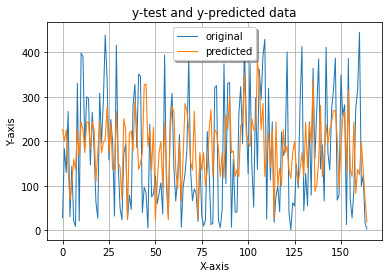

In [20]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

### 6. Improving the model

For this exercise, we'll focus on doing a `RandomizedSearchCV` to tune the hyperparameters.

In [21]:
%%time

rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"]}

rs_model = RandomizedSearchCV(RandomForestRegressor(random_state=25), #random_state sets like np.random.seed()
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 6.31 s
Wall time: 6.3 s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=25),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [22]:
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': None}

In [23]:
# Is there an improvement?

score2 = rs_model.score(X_train, y_train)
print("R-squared", score2)

R-squared 0.3530434319865634


The R^2 value is worse after fitting with the randomized hyperparameters. Let's continue with the ideal parameters and evaluate on that. 

In [24]:
ideal_model = RandomForestRegressor(n_estimators=80,
                                    min_samples_leaf=5,
                                    min_samples_split=10,
                                    max_features="auto",
                                    max_depth=None,
                                    n_jobs=-1,
                                    random_state=25, #so the model is reproducible
                                    max_samples=None)
ideal_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=5, min_samples_split=10, n_estimators=80,
                      n_jobs=-1, random_state=25)

In [25]:
score3 = ideal_model.score(X_train, y_train)
ideal_y_pred = ideal_model.predict(X_test)

ideal_mse = mean_squared_error(y_test, ideal_y_pred)

print("R-squared", score3)
print("Ideal MSE: ", ideal_mse)
print("Ideal RMSE: ", ideal_mse*(1/2.0))

R-squared 0.3530434319865635
Ideal MSE:  13662.024885302462
Ideal RMSE:  6831.012442651231


Unfortunately, even the ideal parameters were only a slight improvement on the MSE, and did not improve the R^2.

Plot the feature importances to see how they relate to our Firmicutes. 

In [27]:
# Plot the feature importance

def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True)) # does pd.DataFrame, .sort_values, and .reset_index all in one; called chaining
    sns.set(rc={'figure.figsize':(10,10)})
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

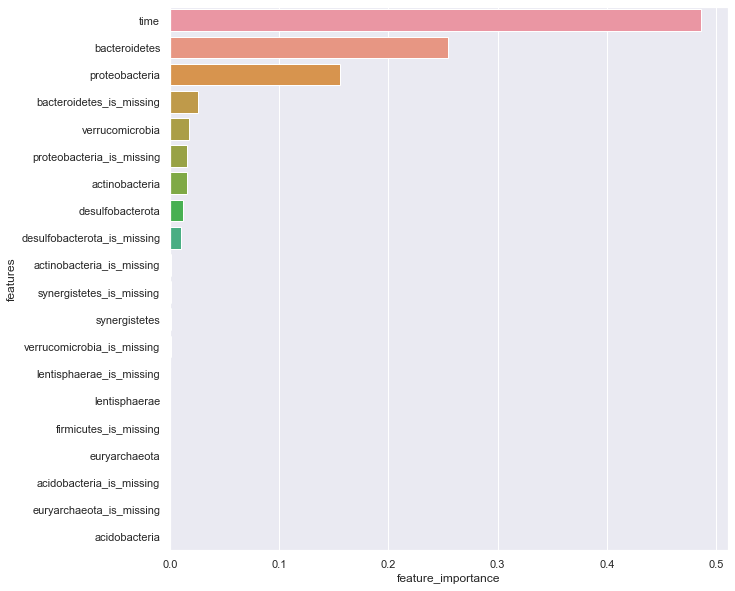

In [28]:
plot_features(X_train.columns, ideal_model.feature_importances_)

## 7. Conclusion and future work

### Summary

Our data seems to be a bit difficult to model, and this may be due to the limitations mentioned above. When looking at the feature importances, it seems that time is the most important variable to the abundance of Firmicutes, followed by the abundance of Bacteroidetes. 

### Next steps

We did not (yet) answer question 2 to see if we can identify the abundance of a phyla given the available data. Perhaps in a next iteration we will split the data into training, validation, and test data to see if we can answer this question. 

One key metric, used in a previous Kaggle competition, is the calculation of mean squared log error, but there seems to be a dimension problem with the data. Once I've found a solution, I will update this with a better model. 

That said, there are other models and hyperparameters that can be tested. This is just an exploratory model on the available data and knowledge.  